### Load needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Load our dataset and view the first five rows

In [2]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


## 1. Data Validation

In [3]:
# Get the shape of our data ie number of rows and columns
rows, columns = df.shape
print('Number of Rows:', rows,'rows')
print('Number of Columns:', columns,'columns')

Number of Rows: 947 rows
Number of Columns: 8 columns


### Our dataset contains 947 rows and 8 columns

### Find below the details of the columns in our dataset as presented

Column Name                                     
- recipe Numeric : unique identifier of recipe
- calories Numeric : number of calories
- carbohydrate Numeric : amount of carbohydrates in grams
- sugar Numeric : amount of sugar in grams
- protein Numeric : amount of protein in grams
- category Character : type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal')
- servings Numeric : number of servings for the recipe
- high_traffic Character : if the traffic to the site was high when this recipe was shown, this is marked with “High”.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [5]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


### Lets check for duplicates

In [6]:
df.duplicated().sum()

0

### There are no duplicate in our dataset

### Lets check for null values

In [7]:
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

#### We have some 52 null values in several columns such as calories,carbohydrate,sugar,protein and 373 null values in high_traffic column.


### Let's investigate

In [8]:
# Let get high_traffic
df['high_traffic'].value_counts()

High    574
Name: high_traffic, dtype: int64

#### For the high_traffic column our data shows that only 'High' traffic were recorded
#### The null values are actually not missing but low traffic.
### We impute the null values as 'Low' traffic.

In [9]:
df["high_traffic"] = df["high_traffic"].fillna(value='Low')
df['high_traffic'].value_counts()

High    574
Low     373
Name: high_traffic, dtype: int64

### Lets plot the distribution of the columns with missing values to ascertain how to impute the null values

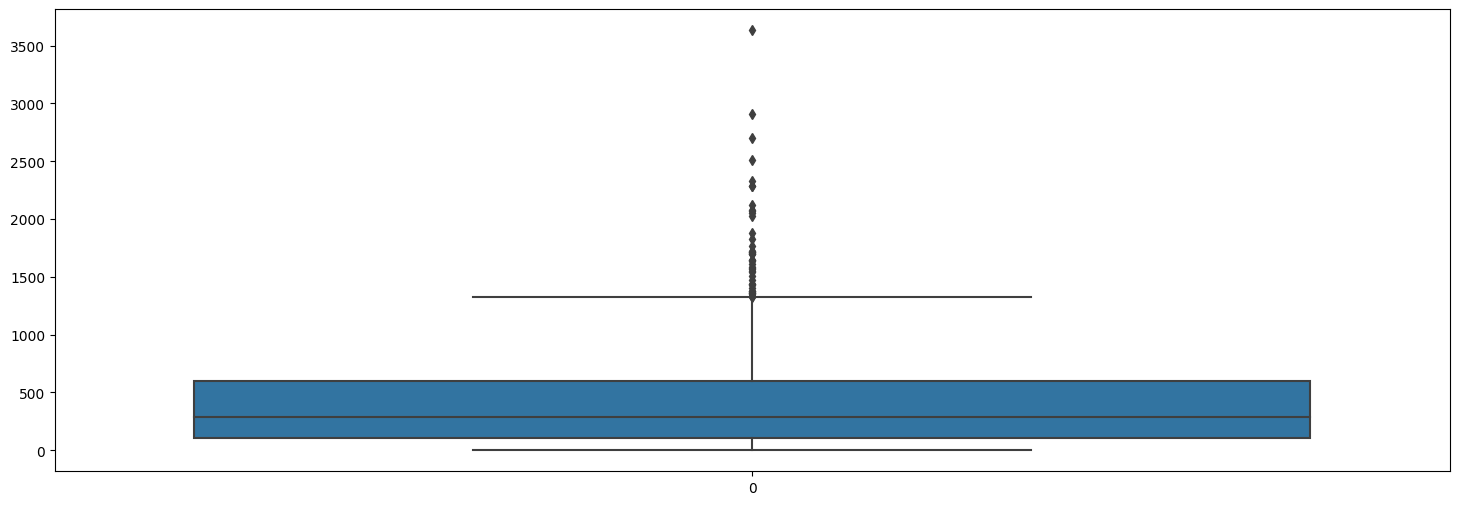

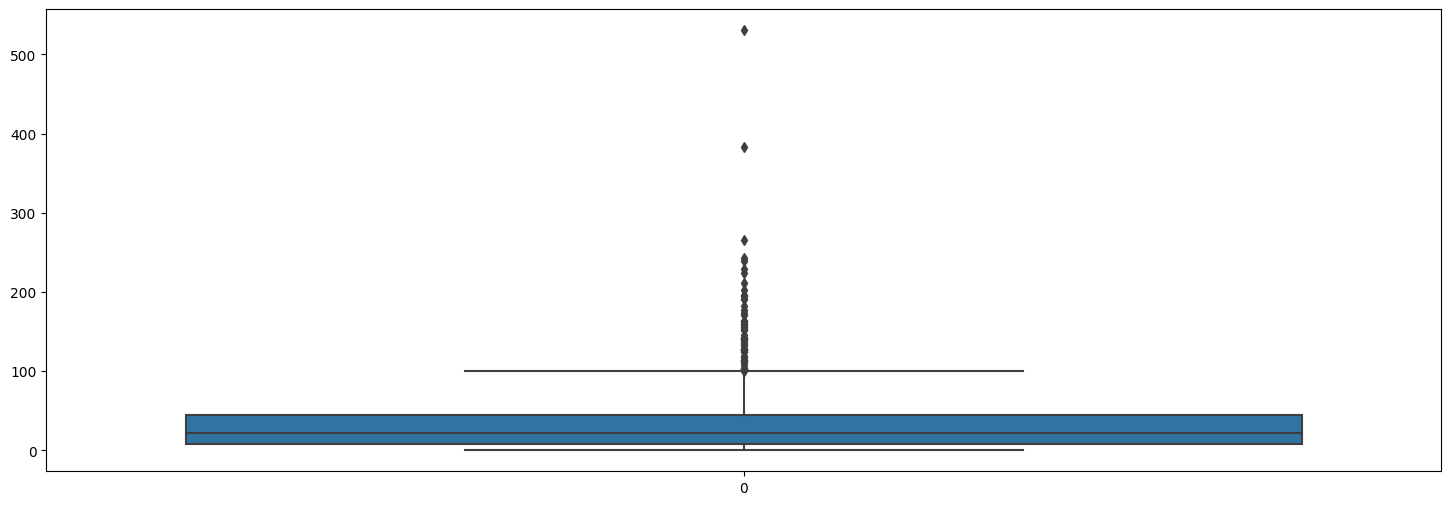

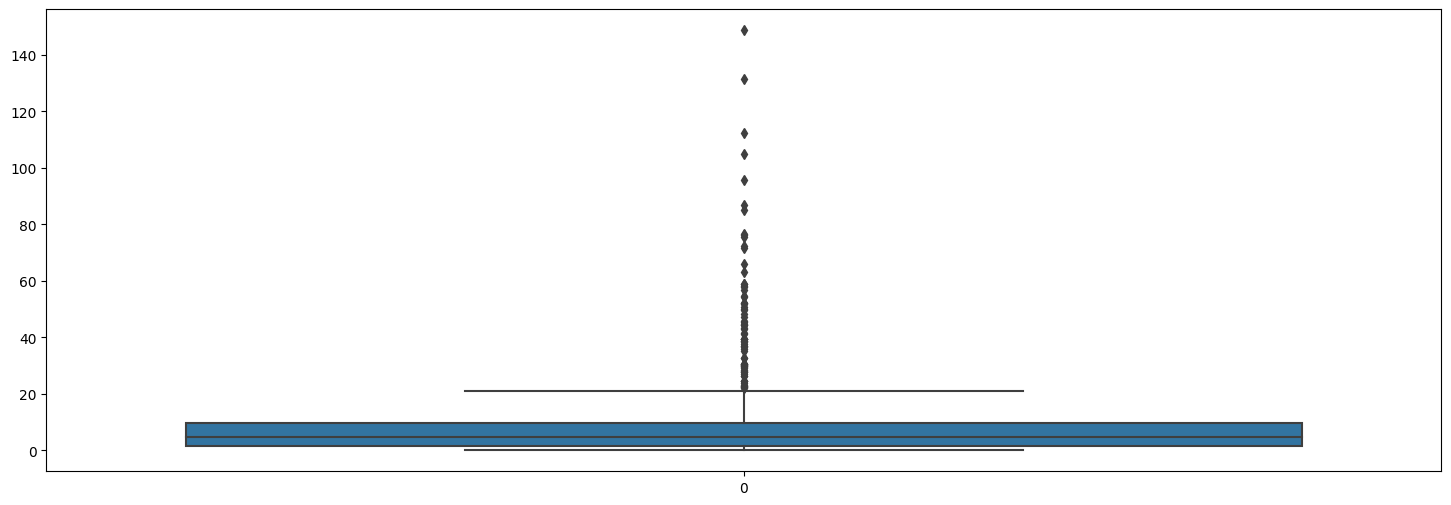

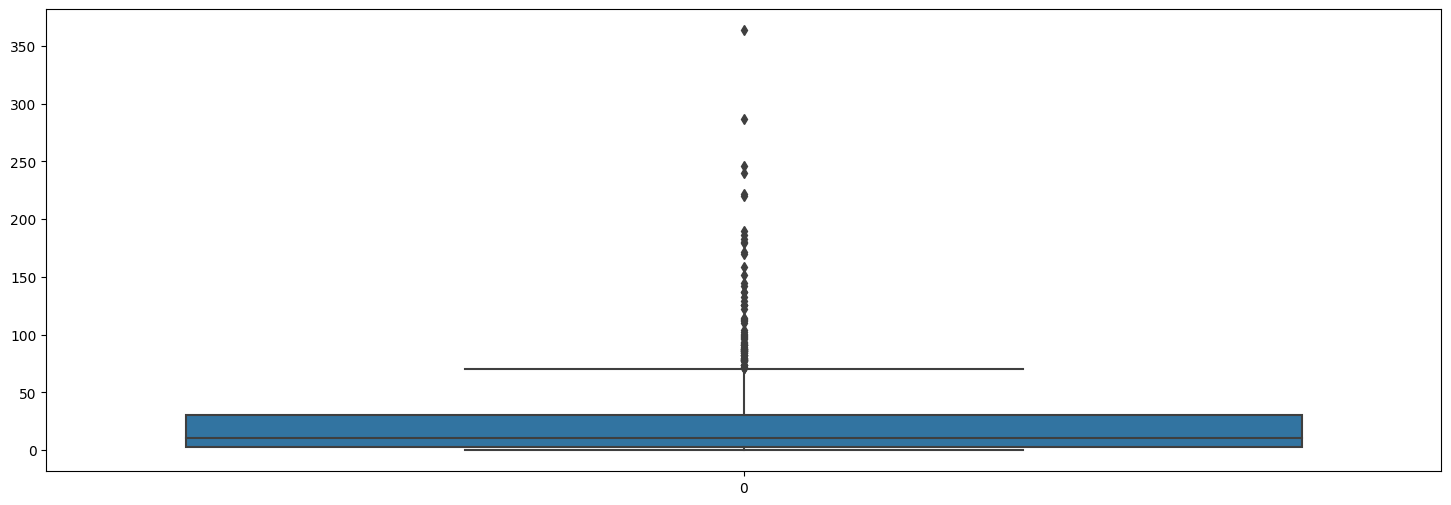

In [10]:
cols = ['calories','carbohydrate','sugar','protein']
for col in cols:
    plt.figure(figsize=(18,6))
    sns.boxplot(df[col])
    plt.show()

### The columns 'calories','carbohydrate','sugar','protein' columns are all right skewwed with outliers. So using the median as imputation is much better

In [11]:
df["calories"] = df["calories"].fillna(df["calories"].median())
df["carbohydrate"] = df["carbohydrate"].fillna(df["carbohydrate"].median())
df["sugar"] = df["sugar"].fillna(df["sugar"].median())
df["protein"] = df["protein"].fillna(df["protein"].median())

### Lets Check for null values after imputation to ascertain.

In [12]:
df.isnull().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

### Our Dataset has no missing values

### Lets investigate the servings column. It was presented as numeric type but our info shows it is object type.

In [13]:
df['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

### We will remove all strings in the contents

In [14]:
df['servings'] = df['servings'].str.replace(' as a snack','')
df['servings'].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

### The servings column is 'object', we will convert it to float. 

In [15]:
# Let convert the 'servings' column to integers
df['servings'] = df['servings'].astype(int)

### Lets investigate the category column.

In [16]:
df['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

In [17]:
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

### The category are listed in eleven (11) possible groups instead of ten (10)

### Lets replace 'Chicken Breast' with 'Chicken'

In [18]:
df['category'] = df['category'].str.replace('Chicken Breast','Chicken')
df['category'].value_counts()

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

In [19]:
#Lets check our Unique values
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

### Lets validate our dataset

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int32  
 7   high_traffic  947 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(2)
memory usage: 55.6+ KB


### Find below the details of the columns in our dataset after Cleaning and Validation.

Column Name                                     
- recipe (Numeric) : unique identifier of recipe with 947 unique recipe as espected.

- calories (Numeric) : number of calories. It has 52 missing values and are more than 5% of our dataset, which were replaced by the median.

- carbohydrate (Numeric) : amount of carbohydrates in grams. It has 52 missing values and are more than 5% of our dataset, which were replaced by the median.

- sugar (Numeric) : amount of sugar in grams. It has 52 missing values and are more than 5% of our dataset, which were replaced by the median.

- protein (Numeric) : amount of protein in grams. It has 52 missing values and are more than 5% of our dataset, which were replaced by the median.

- category (Character) : type of recipe. Recipes were listed in one of eleven (11) possible groupings instead of ten (10) possible groupings. The 'Chicken Breast' was merge with the 'Chicken' variable. we have 10 possible groupings.


- servings (Object) : number of servings for the recipe: They were Six (6) possible instead of Four (4) possible groupings. The strings attached to some numbers were removed. We now have Four possible grouping of 1, 2, 4, 6. The column was also presented as object, we converted it back to numeric.


- high_traffic (Character) : if the traffic to the site was high when this recipe was shown, this is marked with “High”. It has 373 null values. We impute the null values as 'Low' traffic.

### Our Dataset has been cleaned, all variables validated and imputation has been carried out successfully.



## EXPLORATORY DATA ANALYSIS

In [21]:
df['high_traffic'].value_counts(normalize=True)

High    0.606125
Low     0.393875
Name: high_traffic, dtype: float64

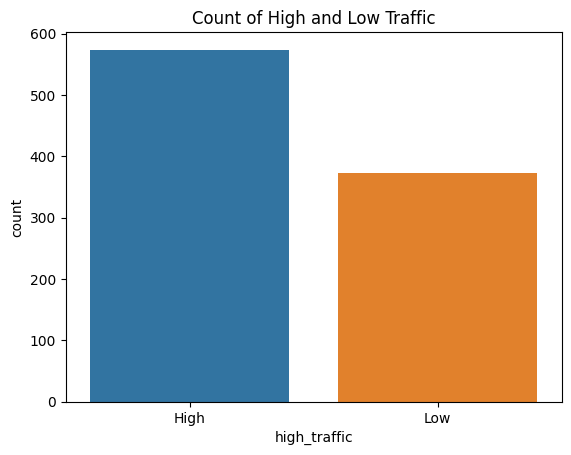

In [22]:
# Lets plot for 'high_traffic' column
sns.countplot(x='high_traffic',data=df)
plt.title('Count of High and Low Traffic')
plt.show()

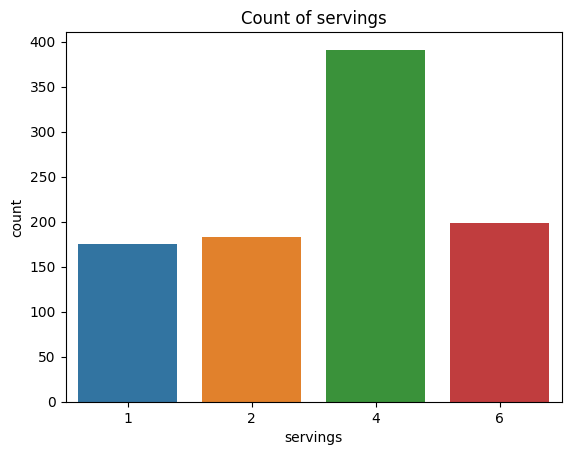

In [23]:
# Lets plot for 'servings' column
sns.countplot(x='servings',data=df)
plt.title('Count of servings')
plt.show()

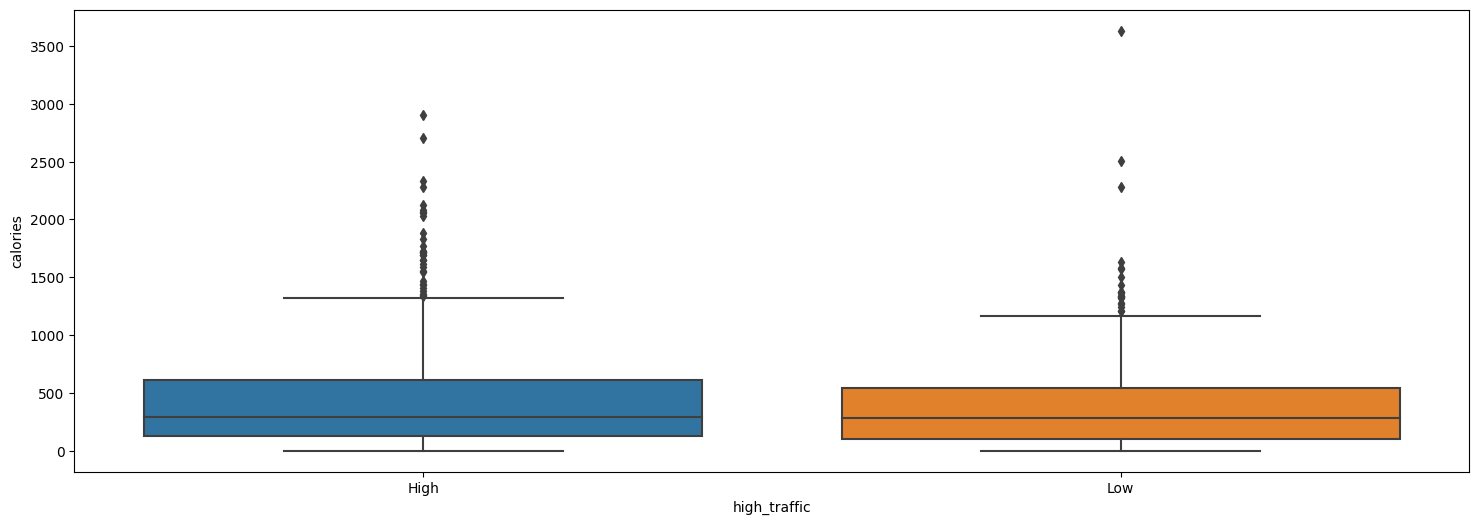

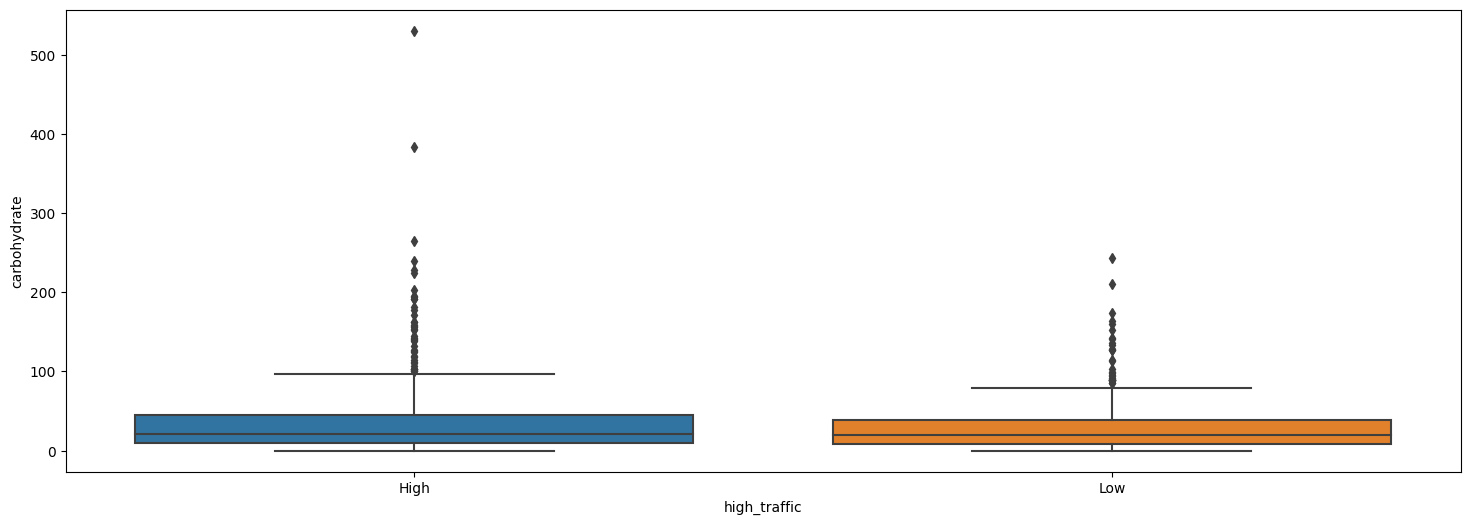

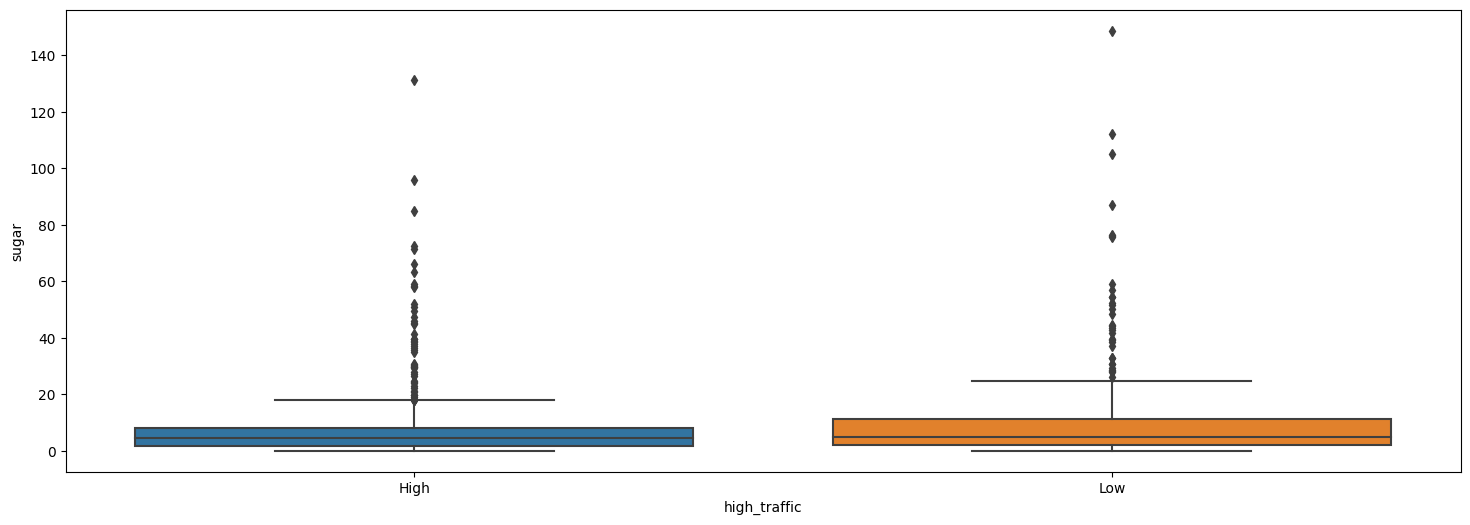

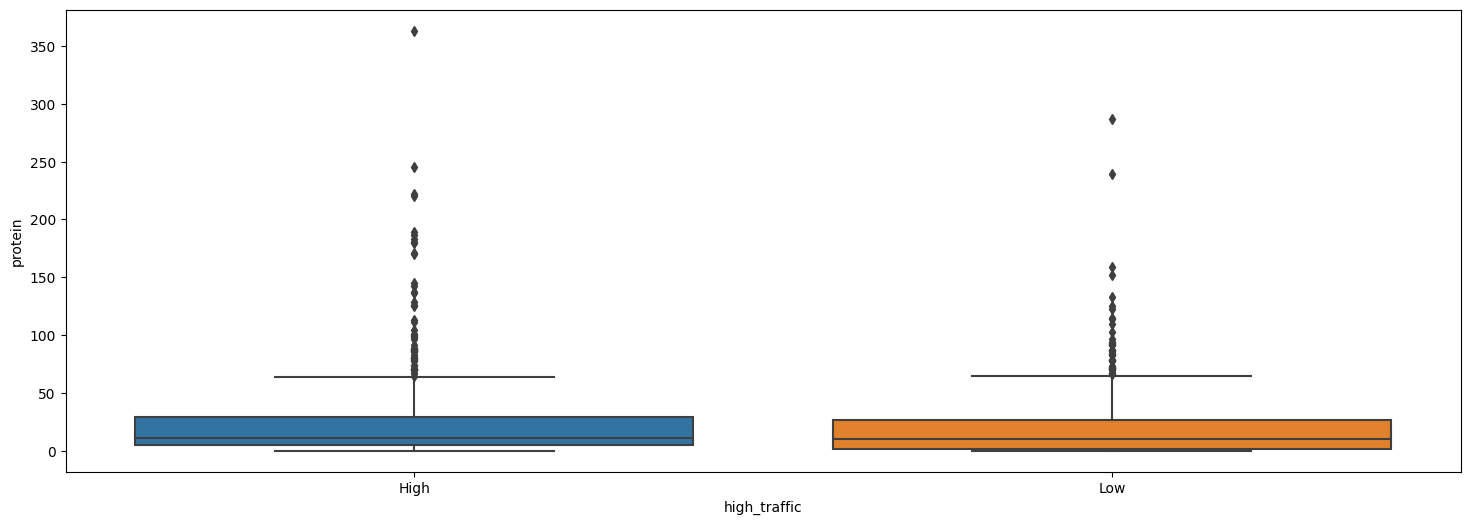

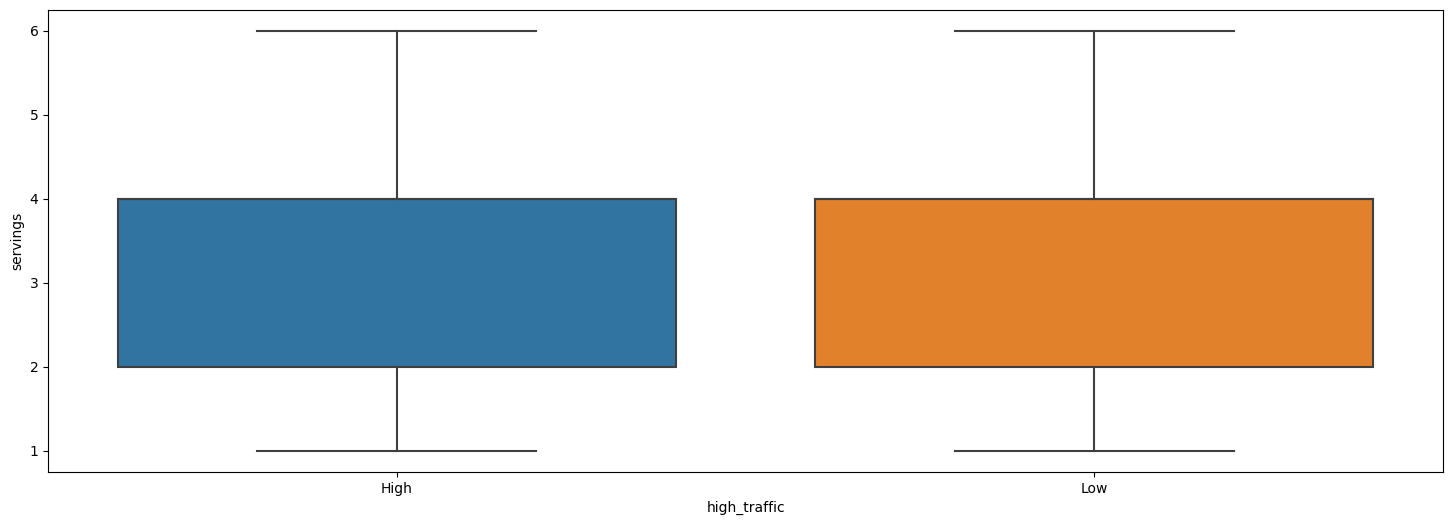

In [24]:
numCols = df.select_dtypes([np.number]).columns.drop('recipe')
for col in numCols:
    plt.figure(figsize=(18,6))
    sns.boxplot(x=df['high_traffic'], y=col, data=df)
    plt.show()

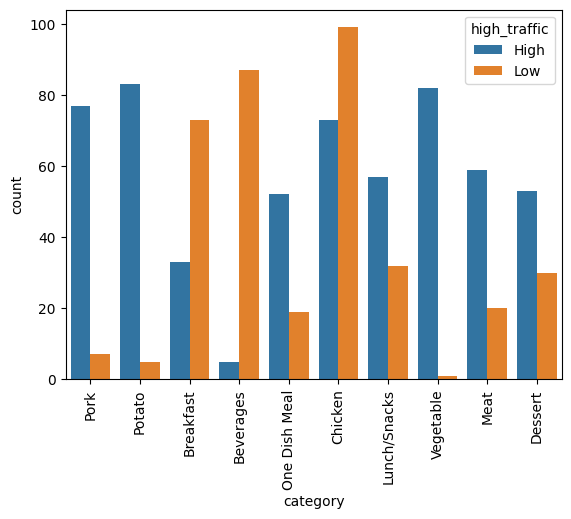

In [25]:
sns.countplot(x=df['category'], data=df, hue='high_traffic')
plt.xticks(rotation=90)
plt.show()

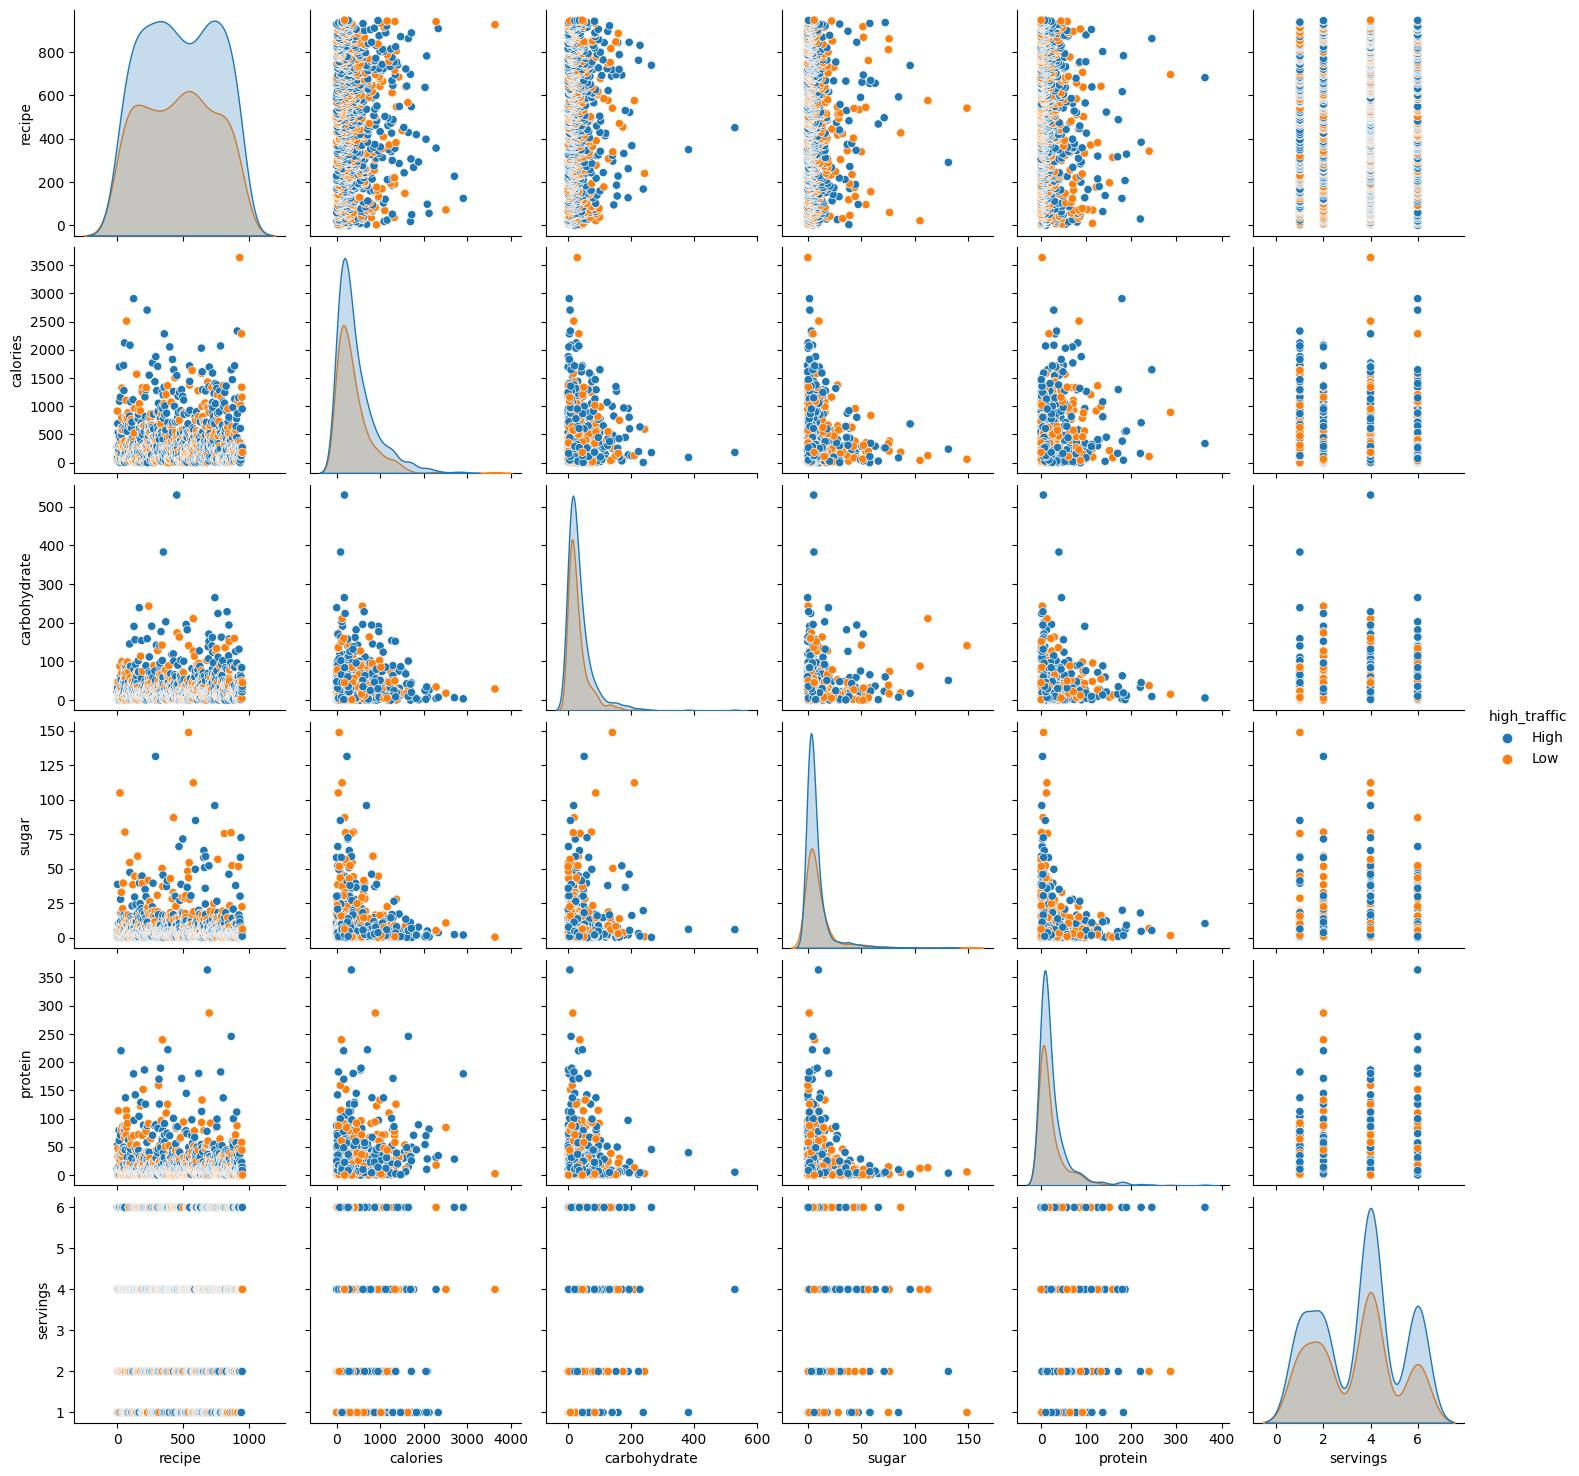

In [26]:
sns.pairplot(df, hue='high_traffic')
plt.show()

### Observations

1. Our high_traffic columns has 60% High and 40% Low traffic 
2. The 'calories', 'protein' and 'cabohydrate' as little effect on the high traffic.
3. A high 'sugar' tends to leads to a low traffic.
4. The category(Pork,Potato,One Dish Meal,Lunch/Snacks,Vegetable,Meat,Desert) contains in the recipe has a higher traffic.
5. The servings 4 has the highest count
6. The servings has no significant effect on traffic.

## Modeling

### Lets do encoding with get_dummies on the category columns

In [27]:
df = pd.get_dummies(df, columns= ["category"], drop_first=False)
df.head()

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
0,1,288.55,21.48,4.55,10.80,6,High,0,0,0,0,0,0,0,1,0,0
1,2,35.48,38.56,0.66,0.92,4,High,0,0,0,0,0,0,0,0,1,0
2,3,914.28,42.68,3.09,2.88,1,Low,0,1,0,0,0,0,0,0,0,0
3,4,97.03,30.56,38.63,0.02,4,High,1,0,0,0,0,0,0,0,0,0
4,5,27.05,1.85,0.80,0.53,4,Low,1,0,0,0,0,0,0,0,0,0


In [28]:
df.dtypes

recipe                      int64
calories                  float64
carbohydrate              float64
sugar                     float64
protein                   float64
servings                    int32
high_traffic               object
category_Beverages          uint8
category_Breakfast          uint8
category_Chicken            uint8
category_Dessert            uint8
category_Lunch/Snacks       uint8
category_Meat               uint8
category_One Dish Meal      uint8
category_Pork               uint8
category_Potato             uint8
category_Vegetable          uint8
dtype: object

In [29]:
df["high_traffic"] = df["high_traffic"].map({"High": 1, "Low": 0})

In [30]:
# Lets Check the class weight of our features
df["high_traffic"].value_counts(normalize=True)

1    0.606125
0    0.393875
Name: high_traffic, dtype: float64

### The class weight of high_traffic is not balance but it is not greatly unbalanced. We have 60% for High traffic and 40% for Low traffic.

### The problem is to predict recipe that produces high traffic. This is a **CLASSIFICATION** problem

We drop the recipe column because it contains no information. It is a unique identifier of recipe

Target is the 'high_traffic' column and it is map by y

Lets map our features as X

In [31]:
X = df[df.columns.drop(["recipe","high_traffic"])]
y = df[['high_traffic']]

### Lets split into Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=y, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (662, 15) (662, 1)
Test set: (285, 15) (285, 1)


### Let train a baseline using Decision Tree

In [33]:
# Lets fit with a baseline model DecisionTree Classifier
dt = DecisionTreeClassifier(random_state=4) #random_state = 4 for reproducibility
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=4)

In [34]:
predT = dt.predict(X_test)

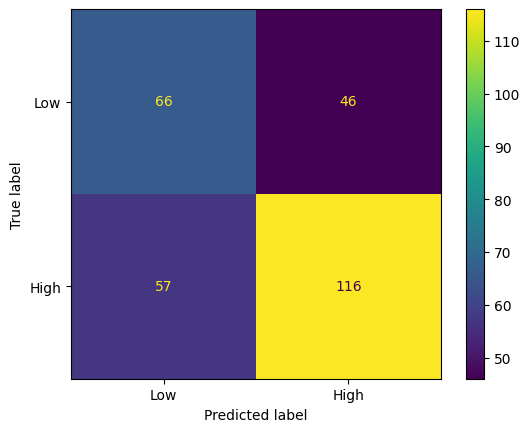

In [35]:
confusion_matrix = metrics.confusion_matrix(y_test, predT)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Low', 'High'])
cm_display.plot()
plt.show()

In [36]:
precision, recall, f_beta, support = metrics.precision_recall_fscore_support(y_test, predT, beta=5, pos_label= 1, average='binary')
auc = metrics.roc_auc_score(y_test, predT)
accuracy = metrics.accuracy_score(y_test, predT)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.64
Precision is: 0.72
Recall is: 0.67
Fscore is: 0.67
AUC is: 0.63


### Lets fit a comparison model (Logistic Regression)

In [51]:
LR = LogisticRegression(random_state=4)
LR.fit(X_train, y_train)

LogisticRegression(random_state=4)

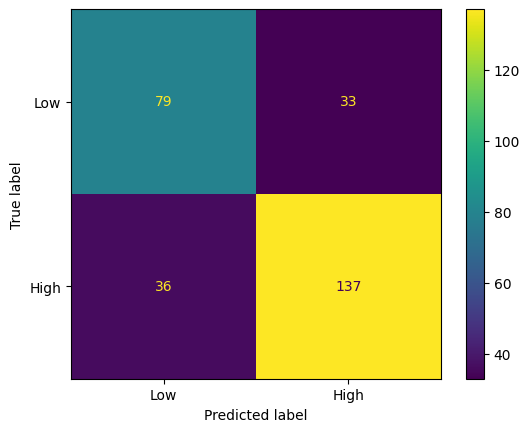

In [52]:
yhat = LR.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, yhat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Low', 'High'])
cm_display.plot()
plt.show()

In [53]:
precision1, recall1, f_beta1, support1 = metrics.precision_recall_fscore_support(y_test, yhat, beta=5, pos_label=1, average='binary')
auc1 = metrics.roc_auc_score(y_test, yhat)
accuracy1 = metrics.accuracy_score(y_test, yhat)
print(f"Accuracy is: {accuracy1:.2f}")
print(f"Precision is: {precision1:.2f}")
print(f"Recall is: {recall1:.2f}")
print(f"Fscore is: {f_beta1:.2f}")
print(f"AUC is: {auc1:.2f}")

Accuracy is: 0.76
Precision is: 0.81
Recall is: 0.79
Fscore is: 0.79
AUC is: 0.75


### MODEL EVALUATION

In [54]:
Report = pd.DataFrame({'Algorithm' : ['Decision Trees', 'LogisticRegression']})
Report['Accuracy'] = [accuracy, accuracy1]
Report['Precision'] = [precision, precision1]
Report['Recall'] = [recall, recall1]
Report['AUC'] = [auc, auc1]
Report['F1-Score'] = [f_beta, f_beta1]
Report

,Algorithm,Accuracy,Precision,Recall,AUC,F1-Score
0,Decision Trees,0.638596,0.716049,0.670520,0.629903,0.672164
1,LogisticRegression,0.757895,0.805882,0.791908,0.748632,0.792436


### Description of the performance of the two models based on an appropriate metric

1. **ACCURACY** : Accuracy is the proportion of data points that are correctly classified. It is an overall representation of model performance. The base model has an accuracy of 64% while the comparison model has an accuracy of 76%. The comparison model(Logistic Regression) was able to correctly classify 76% of the trafiic.

2. **PRECISION** : Precision measures the proportion of positive predictions that are true positives. The base model was able to predict 72% proportion of High Traffic while the comparison model was able to predict 80% proportion of High Traffic. Precision is a good metric to use when it’s important to avoid false positives(Low Traffic predicted as High Traffic)

3. **RECALL** : Recall measures the proportion of data points that are correctly classified. The base model was able to predict 67% proportion of High Traffic while the comparison model was able to predict 80% proportion of High Traffic. Recall is a good metric to use when it’s important that you identify as many True responders as possible.

4. **AREA UNDER CURVE(AUC)** : AUC provides an aggregate measure of performance across all possible classification thresholds. One way to interpret AUC is to consider it as the probability that the model ranks a random positive sample more highly than a random negative sample. The base model has an AUC of 0.63(better than a random guess which is 0.5), while the comparison model has a higher AUC of 0.75.

5. **F1_SCORE** : F1 score is a measurement that combines both precision and recall into a single expression, giving each equal importance. The base model has a F1_Score of 67% while the comparison model has a much higher F1_Score of 79%

### Lets get the important features for predicting our high_traffic target

<Axes: xlabel='Feature'>

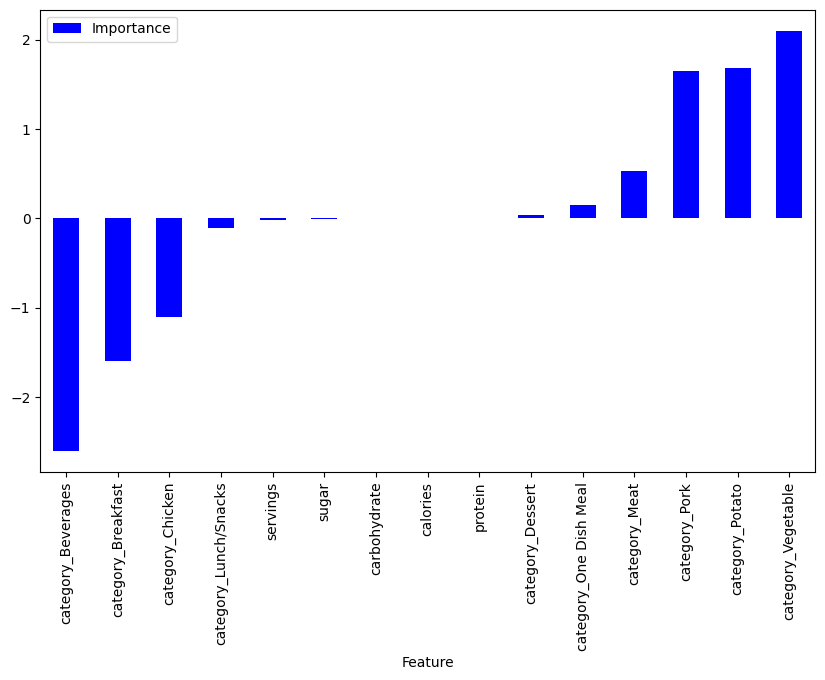

In [55]:
coefficients = LR.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='bar', figsize=(10, 6), color='b')

## Definition of a metric for the business to monitor

**1. The business goal is to increase website traffic. More traffic means more subscriptions so this is really important to the company.**


**2. The Key Perfomance Indicators (KPI) in this case is the percentage of High traffic.**

**3. Establish a baseline: Choosing a favorite recipe from a selection and display that on the home page. We have noticed that traffic to the rest of the website goes up by as much as 40%.**

**4. With our baseline model we can predict the High traffic 72% while our comparision model can predict the High Traffic 81% precision metrics.**




## Summary and Recommendations

### The target (high_traffic) is unbalanced but not highly unbalanced. Our Models made resonable predictions for the target, which is better than random guessing.

### The most important features in deciding the High Traffic are (positive coefficient features);
1. category_Vegetable
2. category_Pork
3. category_Potato
4. category_Meat
5. category_One Dish Meal
6. category_Dessert

#### A positive coefficient means that an increase in the feature value will increase the log odds of the positive class, making it more likely to predict High traffic.

### The most important features in deciding the Low Traffic are (negative coefficient features);
1. category_Beverages
2. category_Breakfast
3. category_Chicken
4. servings

#### A negative coefficient means that an increase in the feature value will decrease the log odds of the positive class, making it less likely.

### They should monitor the above features for both "High" and "Low" traffic.

## Recommendation
1. We need to carry out hyperparameter tuning to improved our models predictions.
2. The Company needs to put measures in place to monitor the most important features for both "High" and "Low" traffic predictions.

